<a href="https://colab.research.google.com/github/martin-galajda/object-detection/blob/master/notebooks/EvaluationOpenImagesSubset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

THESIS_RESOURCES_DIR = "/content/drive/My Drive/object-detection-thesis"

%cd '/content/drive/My Drive/object-detection-thesis/object-detection'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/object-detection-thesis/object-detection


In [0]:
%cd '/content/drive/My Drive/object-detection-thesis'
! git clone https://github.com/martinGalajdaSchool/object-detection.git
! pwd
%cd '/content/drive/My Drive/object-detection-thesis/object-detection'
! git pull origin master

/content/drive/My Drive/object-detection-thesis
fatal: destination path 'object-detection' already exists and is not an empty directory.
/content/drive/My Drive/object-detection-thesis
/content/drive/My Drive/object-detection-thesis/object-detection
From https://github.com/martinGalajdaSchool/object-detection
 * branch            master     -> FETCH_HEAD
Already up to date.


# Define utility functions

In [0]:
from evaluation.average_precision.results import EvaluationResults
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict
import numpy as np

BASE_OUTPUT_PATH_FOR_PLOTS = f'{THESIS_RESOURCES_DIR}/evaluation/plots'
BASE_OUTPUT_PATH_AP_RESULTS = f'{THESIS_RESOURCES_DIR}/mAP-benchmark-results'
PATH_TO_AP_RESULTS_CSV_FILES = f'{BASE_OUTPUT_PATH_AP_RESULTS}/csv_files'

def concatenate_files_in_dir(dir_path: str):
  files_in_dir = os.listdir(dir_path)
  files_in_dir = [file_in_dir for file_in_dir in files_in_dir if file_in_dir.contains('.csv')]

  
def show_values_on_bars(axs):
  def _show_on_single_plot(ax):        
      for p in ax.patches:
          _x = p.get_x() + p.get_width() / 2
          _y = p.get_y() + p.get_height()
          value = '{:.2f}'.format(p.get_height())
          ax.text(_x, _y, value, ha="center") 

  if isinstance(axs, np.ndarray):
      for idx, ax in np.ndenumerate(axs):
          _show_on_single_plot(ax)
  else:
      _show_on_single_plot(axs)


def create_and_save_AP_plot(results: EvaluationResults, model_name: str, num_of_important_AP_to_visualize: int = 30):
  """
  Creates plot for comparing AP metrics for different classes and saves it on GDrive.

  Args:
    - results: evaluation results containing AP results for each class
    - model_name: name of the model, used for generating plot title and output path for the saved plot
    - num_of_important_AP_to_visualize: optional number for top and bottom APs to visualize, defaults to 30

  """
  sns.set(rc={ 'figure.figsize': (25, 25 )})
  sns.set(font_scale=1.7)

  data_for_plot = []
  for class_label, AP_value in results.AP_per_class.items():
    data_for_plot.append([class_label, AP_value * 100])

  cols = ["class", "AP"]

  # sort by AP, in decreasing fashion
  data_for_plot = list(sorted(data_for_plot, key=lambda elem: elem[1],  reverse=True))
  data_for_plot_top_ap = data_for_plot[:num_of_important_AP_to_visualize]
  dataframe_for_plot_top_ap = pd.DataFrame(data_for_plot_top_ap, columns=cols)

  fig_top_ap, ax_top_ap = plt.subplots()
  sns_top = sns.barplot(x=cols[0], y=cols[1], data=dataframe_for_plot_top_ap, ax=ax_top_ap)
  plt.xticks(rotation=90)
  sns_top.set(ylim=(0, 100), title="")
  show_values_on_bars(ax_top_ap)


  output_path_grap_top_ap = f'{BASE_OUTPUT_PATH_FOR_PLOTS}/{model_name}_top_{num_of_important_AP_to_visualize}_AP_plot.png'
  fig_top_ap.savefig(output_path_grap_top_ap)

  data_for_plot_bottom_ap = data_for_plot[-num_of_important_AP_to_visualize:]
  dataframe_for_plot_bottom_ap = pd.DataFrame(data_for_plot_bottom_ap, columns=cols)

  fig_bottom_ap, ax_bottom_ap = plt.subplots()
  sns_botom = sns.barplot(x=cols[0], y=cols[1], data=dataframe_for_plot_bottom_ap, ax=ax_bottom_ap)
  sns_botom.set(ylim=(0, 100), title="")
  plt.xticks(rotation=90)
  show_values_on_bars(ax_bottom_ap)
  plt.tight_layout()

  output_path_grap_bottom = f'{BASE_OUTPUT_PATH_FOR_PLOTS}/{model_name}_bottom_{num_of_important_AP_to_visualize}_AP_plot.png'
  fig_bottom_ap.savefig(output_path_grap_bottom)

def create_and_save_mAP_plot(results_for_models: Dict[str, EvaluationResults], dataset: str):
  """

  Creates plot for comparing mAP metrics for different models and saves it on GDrive.

  Args:
    - results_for_models: dictionary mapping from model name to evaluation results

  """
  sns.set(rc={ 'figure.figsize': (10, 10 )})
  sns.set(font_scale=1.7)

  data_for_plot = []
  for model_name, evaluation_results in results_for_models.items():
    data_for_plot.append([model_name, evaluation_results.mAP * 100])

  cols = ["model", "mAP"]
  dataframe_for_plot = pd.DataFrame(data_for_plot, columns=cols)

  fig, ax = plt.subplots()
  sns_plot = sns.barplot(x=cols[0], y=cols[1], data=dataframe_for_plot, ax=ax)
  sns_plot.set(ylim=(0, 100), title=f'mAP comparison for models')
  # plt.xticks(rotation=90)
  show_values_on_bars(ax)

  output_path_plot = f'{BASE_OUTPUT_PATH_FOR_PLOTS}/mAP_comparison_{dataset}.png'
  fig.savefig(output_path_plot)

def save_AP_results(results_for_models: Dict[str, EvaluationResults], iou_threshold: str):
  """

  Saves AP results after computing it with certain threshold.

  Args:
    - results_for_models: dictionary mapping from model name to evaluation results
    - iou_threshold: threshold for considering detected box as true

  """

  path_to_current_csv_file = f'{PATH_TO_AP_RESULTS_CSV_FILES}/ap_results@{iou_threshold}.csv'

  data_for_plot = []
  for model_name, evaluation_results in results_for_models.items():
    data_for_plot.append([model_name, evaluation_results.mAP * 100, iou_threshold])

  cols = ["model", "mAP", "iou_threshold"]
  dataframe_for_plot = pd.DataFrame(data_for_plot, columns=cols)

  dataframe_for_plot.to_csv(path_to_current_csv_file)

# Generate detections for YOLOv3

In [0]:
from evaluation.run_detections import ObjectDetectorOptions, generate_detections_files

INPUT_PATH_IMAGES = f'{THESIS_RESOURCES_DIR}/openimages-test-images'
OUTPUT_PATH_DETECTIONS = f'{THESIS_RESOURCES_DIR}/mAP-benchmark-results/detected_openimages/'

PATH_TO_YOLOV3_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/yolov3"
PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'
PATH_TO_YOLOV3_CLASSES = f'{PATH_TO_YOLOV3_RESOURCES}/openimages.names'

generate_detections_files(
    INPUT_PATH_IMAGES,
    OUTPUT_PATH_DETECTIONS,
    ObjectDetectorOptions.YOLOV3,
    {
      'verbose': False,
      'path_to_model': PATH_TO_YOLOV3_MODEL,
      'path_to_classes': PATH_TO_YOLOV3_CLASSES,
      'log_device_placement': False,
      'detection_threshold': 0.0005
    }
)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Took 30.451497316360474 seconds to construct network.
Ignored files(0): 
[]


# Generate detections for Faster R-CNNN

In [0]:
from evaluation.run_detections import ObjectDetectorOptions, generate_detections_files

INPUT_PATH_IMAGES = f'{THESIS_RESOURCES_DIR}/openimages-test-images'
OUTPUT_PATH_DETECTIONS = f'{THESIS_RESOURCES_DIR}/mAP-benchmark-results/detected_openimages/'

PATH_TO_FASTER_RCNN_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/faster_rcnn"
PATH_TO_FASTER_RCNN_INFERENCE_GRAPH = f'{PATH_TO_FASTER_RCNN_RESOURCES}/for_map/frozen_inference_graph.pb'
PATH_TO_FASTER_RCNN_CLASSES = f'{PATH_TO_FASTER_RCNN_RESOURCES}/oid_v4_label_map.pbtxt'

generate_detections_files(
    INPUT_PATH_IMAGES,
    OUTPUT_PATH_DETECTIONS,
    ObjectDetectorOptions.FASTER_RCNN,
    {
      'path_to_frozen_graph': PATH_TO_FASTER_RCNN_INFERENCE_GRAPH,
      'path_to_classes': PATH_TO_FASTER_RCNN_CLASSES,
      'use_gpu': True,
      'log_device_placement': False,
    }
)

Using TensorFlow backend.






Ignored files(0): 
[]



# Computing results for YOLOv3 

In [0]:
GT_BOXES_DIR_PATH = f'{THESIS_RESOURCES_DIR}/evaluation/ground_truth_openimages'
DETECTED_BOXES_DIR_PATH = f'{THESIS_RESOURCES_DIR}/mAP-benchmark-results/detected_openimages/openimages-test-images/YOLOv3'

from evaluation.average_precision.evaluator import Evaluator
from evaluation.average_precision.bounding_box_loader import BoundingBoxLoader

ground_truth_bounding_boxes, detected_bounding_boxes = BoundingBoxLoader.loadBoxesFromFiles(
    path_to_detected_files_dir=DETECTED_BOXES_DIR_PATH,
    path_to_gt_files_dir=GT_BOXES_DIR_PATH
)

evaluator = Evaluator(
    detected_bounding_boxes=detected_bounding_boxes,
    ground_truth_bounding_boxes=ground_truth_bounding_boxes,
    drop_empty_gt_files=False
)

results_yolov3 = evaluator.evaluate()

results_yolov3

In [0]:
results_yolov3.mAP

0.2899205591336438

# Computing results for Faster R-CNN

In [0]:
GT_BOXES_DIR_PATH = f'{THESIS_RESOURCES_DIR}/evaluation/ground_truth_openimages'
DETECTED_BOXES_DIR_PATH = f'{THESIS_RESOURCES_DIR}/mAP-benchmark-results/detected_openimages/openimages-test-images/FasterRCNN'

from evaluation.average_precision.evaluator import Evaluator
from evaluation.average_precision.bounding_box_loader import BoundingBoxLoader

ground_truth_bounding_boxes, detected_bounding_boxes = BoundingBoxLoader.loadBoxesFromFiles(
    path_to_detected_files_dir=DETECTED_BOXES_DIR_PATH,
    path_to_gt_files_dir=GT_BOXES_DIR_PATH
)

evaluator = Evaluator(
    detected_bounding_boxes=detected_bounding_boxes,
    ground_truth_bounding_boxes=ground_truth_bounding_boxes,
    drop_empty_gt_files=False
)

results_faster_rcnn = evaluator.evaluate()

results_faster_rcnn

In [0]:
results_faster_rcnn.mAP

0.5358144088165393

# Create mAP plots

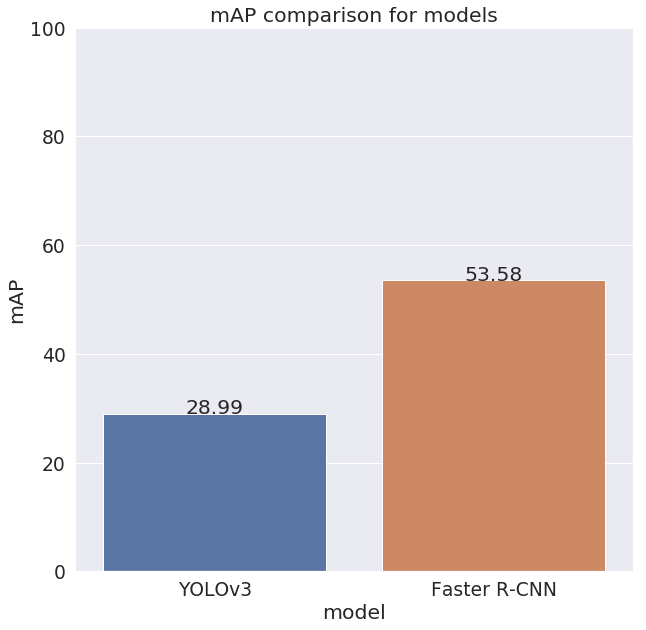

In [0]:
create_and_save_mAP_plot({
    'YOLOv3': results_yolov3,
    'Faster R-CNN': results_faster_rcnn
}, 'openimages')